### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 08 декабря 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 08 декабря, -4 балла после 08:30 15 декабря, -6 баллов после 08:30 22 декабря, -8 баллов после 08:30 29 декабря.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from collections import defaultdict

In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0,
                 criterion='gini', max_features=None):
        self.tree = dict()
        self.impurities = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = None
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass
        else:
            print('invalid criterion name')
            raise

        if max_features == 'sqrt':
            self.get_feature_ids = self.__get_feature_ids_sqrt
        elif max_features == 'log2':
            self.get_feature_ids = self.__get_feature_ids_log2
        elif max_features == None:
            self.get_feature_ids = self.__get_feature_ids_N
        else:
            print('invalid max_features name')
            raise

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return (l_s * (1 - np.sum((l_c / l_s) ** 2, axis=1)).reshape(-1, 1) +
                r_s * (1 - np.sum((r_c / r_s) ** 2, axis=1)).reshape(-1, 1)) / (l_s + r_s)

    def __entropy(self, l_c, l_s, r_c, r_s):
        return (l_s * (-np.sum((l_c / l_s) * np.log((l_c) / l_s), axis=1)).reshape(-1, 1) +
                r_s * (-np.sum((r_c / r_s) * np.log((r_c) / r_s), axis=1)).reshape(-1, 1)) / (l_s + r_s)

    def __misclass(self, l_c, l_s, r_c, r_s):
        return (l_s * (1 - np.max(l_c / l_s, axis=1)).reshape(-1, 1) +
                r_s * (1 - np.max(r_c / r_s, axis=1)).reshape(-1, 1)) / (l_s + r_s)

    def __get_feature_ids_sqrt(self, n_feature):
        feature_ids = list(range(n_feature))
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.ceil(np.sqrt(n_feature)))]

    def __get_feature_ids_log2(self, n_feature):
        feature_ids = list(range(n_feature))
        np.random.shuffle(feature_ids)
        return feature_ids[:int(np.ceil(np.log2(n_feature)))]

    def __get_feature_ids_N(self, n_feature):
        return list(range(n_feature))

    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        x_sort, y_sort = self.__sort_samples(x, y)

        class_brd = np.where(y_sort[:-1] != y_sort[1:])[0] + 1

        if len(class_brd) == 0:
            return np.inf, None

        eq_el_count = class_brd - np.append([0], class_brd[:-1])
        one_hot_code = np.zeros((class_brd.shape[0], self.num_class))
        one_hot_code[np.arange(class_brd.shape[0]), y_sort[class_brd - 1]] = 1
        class_increments = one_hot_code * eq_el_count.reshape(-1, 1)

        l_c = np.cumsum(class_increments, axis=0)
        r_c = np.bincount(y, minlength=self.num_class) - l_c
        l_s = class_brd.reshape(l_c.shape[0], 1)
        r_s = y_sort.shape[0] - l_s

        gs = self.G_function(l_c, l_s, r_c, r_s)
        idx = np.argmin(gs)

        left_el_id = l_s[idx][0]
        return gs[idx], (x_sort[left_el_id - 1] + x_sort[left_el_id]) / 2.0

    def __fit_node(self, x, y, node_id, depth):
        n_features = x.shape[1]
        bins = np.bincount(y)

        if (depth == self.max_depth
            or y.shape[0] < self.min_samples_split
            or np.unique(y).shape[0] == 1
                or bins.max() >= self.sufficient_share * y.shape[0]):

            self.tree[node_id] = (
                self.LEAF_TYPE, bins.argmax(), bins.max() / n_features)
        else:
            feature_ids = self.get_feature_ids(n_features)
            thresholds = np.array(
                [self.__find_threshold(x[:, idx], y) for idx in feature_ids])
            best_thresh_id = thresholds[:, 0].argmin()

            impurity, threshold = thresholds[best_thresh_id]
            x_l, x_r, y_l, y_r = self.__div_samples(
                x, y, feature_ids[best_thresh_id], threshold)

            if node_id:
                impurities = self.impurities[(node_id - 1) // 2]
                self.feature_importances_[best_thresh_id] += \
                    impurities[0] - impurities[1][node_id % 2] * impurity
            else:
                self.feature_importances_[best_thresh_id] += 1 - impurity

            if y_l.shape[0] == 0 or y_r.shape[0] == 0:
                self.tree[node_id] = (
                    self.LEAF_TYPE, bins.argmax(), bins.max() / n_features)
            else:
                self.tree[node_id] = (self.NON_LEAF_TYPE,
                                      best_thresh_id, threshold)
                self.impurities[node_id] = (impurity, np.array(
                    [y_l.shape[0], y_r.shape[0]]) / y.shape[0])
                self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        self.feature_importances_ = np.zeros(x.shape[1])

        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

        self.feature_importances_ /= self.feature_importances_.sum()

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]

    def __predict_probs(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_probs(x, 2 * node_id + 1)
            else:
                return self.__predict_probs(x, 2 * node_id + 2)
        else:
            return node[2]

    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def predict_proba(self, X):
        return np.array([self.__predict_probs(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

In [63]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = defaultdict(float)
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        best_id = 0
        best_tr = 0
        best_imp = 1
        for feature_id in range(x.shape[1]):
            feature_vals = x[:, feature_id]
            sorted_idx = feature_vals.argsort()
            sorted_f, sorted_cl = feature_vals[sorted_idx], y[sorted_idx]

            cls_change = np.where(sorted_cl[:-1] != sorted_cl[1:])[0] + 1

            if cls_change.size == 0:
                continue

            cls_amount = cls_change - np.hstack(([0], cls_change[:-1]))
            steps = np.zeros((cls_change.shape[0], self.num_class))
            steps[np.arange(cls_change.shape[0]),
                         sorted_cl[cls_change - 1]] = 1
            cls_pos = steps * cls_amount.reshape(-1, 1)

            y_l = np.cumsum(cls_pos, axis=0)
            y_r = np.bincount(y, minlength=self.num_class) - y_l
            y_l_amount = cls_change.reshape(y_l.shape[0], 1)
            y_r_amount = sorted_cl.shape[0] - y_l_amount

            impurity_l = self.__get_impurity(y_l / y_l_amount)
            impurity_r = self.__get_impurity(y_r / y_r_amount)

            inf_change = (y_l_amount / (y_l_amount + y_r_amount)) * impurity_l + \
                (y_r_amount / (y_l_amount + y_r_amount)) * impurity_r
            best_tr_id = np.argmin(inf_change)

            if inf_change[best_tr_id] < best_imp:
                best_imp = inf_change[best_tr_id]
                best_imp = best_imp if type(best_imp) == int else best_imp[0]
                best_tr = (sorted_f[y_l_amount[best_tr_id][0] - 1] + sorted_f[y_l_amount[best_tr_id][0]]) / 2.0
                best_id = feature_id
        mid_probs = np.unique(y, return_counts=True)[1] / y.size
        impurity_m = self.__get_impurity(mid_probs)[0][0]
        self.feature_importances_[best_id] += impurity_m - best_imp
        return best_id, best_tr

    def __get_impurity(self, probs):
        #         unique, counts = np.unique(y, return_counts=True, axis=1)
        #         probs = counts / y.shape[1]
        axis = np.ndim(probs) - 1
        if self.criterion == 'gini':
            impurity = self.__get_gini(probs, axis)
        elif self.criterion == 'entropy':
            impurity = self.__get_entropy(probs, axis)
        else:
            impurity = self.__get_cls_err(probs, axis)
        return impurity.reshape(-1, 1)

    def __get_gini(self, probs, axis):
        return 1 - np.sum(probs ** 2, axis=axis)

    def __get_entropy(self, probs, axis):
        if axis == 1:
            return -np.sum(np.vstack(([np.inf, np.inf], probs[1:-1] * np.log2(probs[1:-1]), [np.inf, np.inf])), axis=axis)
        return -np.sum(probs * np.log2(probs), axis=axis)

    def __get_cls_err(self, probs, axis):
        return 1 - np.max(probs, axis=axis)

    def __prepare_leaf(self, y):
        unique, counts = np.unique(y, return_counts=True)
        max_ind = np.argmax(counts)
        class_n = unique[max_ind]
        prob = counts[max_ind] / y.shape[0]
        return class_n, prob

    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        # Ваш код здесь
        class_n, prob = self.__prepare_leaf(y)
        if y.shape[0] < self.min_samples_split or depth > self.max_depth:
            self.tree[node_id] = (self.LEAF_TYPE, class_n, prob)
            return

        best_feature, best_tr = self.__find_threshold(x, y)

        x_l, x_r, y_l, y_r = self.__div_samples(x, y, best_feature, best_tr)

        if y_l.size == 0 or y_r.size == 0:
            self.tree[node_id] = (self.LEAF_TYPE, class_n, prob)
            return

        self.tree[node_id] = (self.NON_LEAF_TYPE, best_feature, best_tr)

#         self.num_class = np.unique(y_l).size
        self.__fit_node(x_l, y_l, 2 * node_id + 1, depth + 1)

#         self.num_class = np.unique(y_r).size
        self.__fit_node(x_r, y_r, 2 * node_id + 2, depth + 1)

    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0)

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node

    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0)[1] for x in X])

    def predict_proba(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0)[2] for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)

    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [64]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(
    wine.data, wine.target, test_size=0.1, stratify=wine.target)

clf.fit(X_train, y_train)

my_clf.fit(X_train, y_train)

In [65]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.8888888888888888

In [66]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8888888888888888

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [67]:
%time clf.fit(X_train, y_train)

CPU times: user 1.51 ms, sys: 987 µs, total: 2.5 ms
Wall time: 1.4 ms


DecisionTreeClassifier()

In [68]:
%time my_clf.fit(X_train, y_train)

CPU times: user 9.91 ms, sys: 2.25 ms, total: 12.2 ms
Wall time: 10.1 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [9]:
data = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

In [10]:
data = data.iloc[:, :97]

In [11]:
data = data.drop(['id'], axis=1)
data = data.drop(['idg'], axis=1)

In [12]:
data = data.drop(['condtn'], axis=1)

In [13]:
data = data.drop(['round'], axis=1)

In [14]:
data = data.drop(['position', 'positin1'], axis=1)

In [15]:
data = data.drop(['order'], axis=1)

In [16]:
data = data.drop(['partner'], axis=1)

In [17]:
data = data.drop(['age_o', 'race_o', 'pf_o_att',
                  'pf_o_sin', 'pf_o_int',
                  'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
                  'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
                  'amb_o', 'shar_o', 'like_o', 'prob_o', 'met_o'],
                 axis=1)

In [18]:
data = data.dropna(subset=['age'])

In [19]:
data.loc[:, 'field_cd'] = data.loc[:, 'field_cd'].fillna(19)

In [20]:
data = data.drop(['field'], axis=1)

In [21]:
cd_probs = data['field_cd'].value_counts() / data.shape[0]
data['field_cd'].replace(cd_probs, inplace=True)

In [22]:
data = data.drop(['undergra'], axis=1)

In [23]:
data.loc[:, 'mn_sat'] = data.loc[:, 'mn_sat'].str.replace(
    ',', '').astype(np.float)

In [24]:
data.loc[:, 'mn_sat'] = data.loc[:, 'mn_sat'].fillna(data.mn_sat.min())

In [25]:
data.loc[:, 'tuition'] = data.loc[:, 'tuition'].str.replace(
    ',', '').astype(np.float)

In [26]:
data.loc[:, 'mn_sat'] = data.loc[:, 'mn_sat'].fillna(data.tuition.min())

In [27]:
data.loc[:, 'race'] = data.loc[:, 'race'].astype(np.int)

In [28]:
data = data.dropna(subset=['imprelig', 'imprace'])

In [29]:
data = data.drop(['from', 'zipcode'], axis=1)

In [30]:
data.loc[:, 'income'] = data.loc[:, 'income'].str.replace(
    ',', '').astype(np.float)

In [31]:
data = data.drop(['income'], axis=1)

In [32]:
data = data.dropna(subset=['date'])

In [33]:
data.loc[:, 'career_c'] = data.loc[:, 'career_c'].fillna(18)

In [34]:
data = data.drop(['career'], axis=1)

In [35]:
data = data.drop(['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming',
                  'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga'], axis=1)

In [36]:
data = data.drop(['expnum'], axis=1)

In [37]:
data.loc[:, 'temp_totalsum'] = data.loc[:, ['attr1_1', 'sinc1_1',
                                            'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']].sum(axis=1)

In [38]:
data.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1']] = \
    (data.loc[:, ['attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1',
                  'amb1_1', 'shar1_1']].T/data.loc[:, 'temp_totalsum'].T).T * 100

In [39]:
data.loc[:, 'temp_totalsum'] = data.loc[:, ['attr2_1', 'sinc2_1',
                                            'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']].sum(axis=1)

In [40]:
data.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1']] = \
    (data.loc[:, ['attr2_1', 'sinc2_1', 'intel2_1', 'fun2_1',
                  'amb2_1', 'shar2_1']].T/data.loc[:, 'temp_totalsum'].T).T * 100

In [41]:
data = data.drop(['temp_totalsum'], axis=1)

In [42]:
for i in [4, 5]:
    feat = ['attr{}_1'.format(i), 'sinc{}_1'.format(i),
            'intel{}_1'.format(i), 'fun{}_1'.format(i),
            'amb{}_1'.format(i), 'shar{}_1'.format(i)]

    if i != 4:
        feat.remove('shar{}_1'.format(i))

    data = data.drop(feat, axis=1)

In [43]:
data = data.drop(['wave'], axis=1)

In [44]:
data_male = data.query('gender == 1').drop_duplicates(subset=['iid', 'pid'])\
    .drop(['gender'], axis=1)\
    .dropna()
data_female = data.query('gender == 0').drop_duplicates(subset=['iid'])\
    .drop(['gender', 'match', 'int_corr', 'samerace'], axis=1)\
    .dropna()

data_female.columns = data_female.columns + '_f'

In [45]:
data_male.shape

(1427, 34)

In [46]:
data_female.shape

(132, 31)

In [47]:
prep_data = data_male.join(data_female, on='pid')
prep_data = prep_data.drop(['iid', 'pid', 'pid_f'], axis=1)

X = prep_data.drop(['match'], axis=1).to_numpy()
y = prep_data['match'].to_numpy()

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [48]:
from sklearn.metrics import roc_auc_score, f1_score

In [49]:
kf = KFold(n_splits=5, shuffle=True)
for inf_cr in ['gini', 'entropy', 'last']:
    acc_res = []
    ras_res = []
    model = MyDecisionTreeClassifier(criterion=inf_cr)
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        model.fit(X_train, y_train)
        acc_res.append(
            accuracy_score(y_val, model.predict(X_val)))
        ras_res.append(
            roc_auc_score(y_val, model.predict_proba(X_val)))
    print(np.mean(acc_res), np.mean(ras_res))

0.8409250398724083 0.48571949454849045
0.8388467672678199 0.48733703393493444
0.8415777205250888 0.4988510638297872


In [50]:
kf = KFold(n_splits=5, shuffle=True)

depth = {'acc_res': defaultdict(list), 'ras_res': defaultdict(list)}
samples = {'acc_res': defaultdict(list), 'ras_res': defaultdict(list)}

depth_range = range(3, 30, 5)
samples_range = range(1, 20, 2)

for max_depth in depth_range:
    for min_samples_split in samples_range:
        model = MyDecisionTreeClassifier(
            max_depth=max_depth, min_samples_split=min_samples_split)
        acc_res = []
        ras_res = []
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            model.fit(X_train, y_train)
            acc = accuracy_score(y_val, model.predict(X_val))
            ras = roc_auc_score(y_val, model.predict_proba(X_val))

            acc_res.append(acc)
            ras_res.append(ras)

        depth['acc_res'][min_samples_split].append(np.mean(acc_res))
        depth['ras_res'][min_samples_split].append(np.mean(ras_res))
        samples['acc_res'][max_depth].append(np.mean(acc_res))
        samples['ras_res'][max_depth].append(np.mean(ras_res))

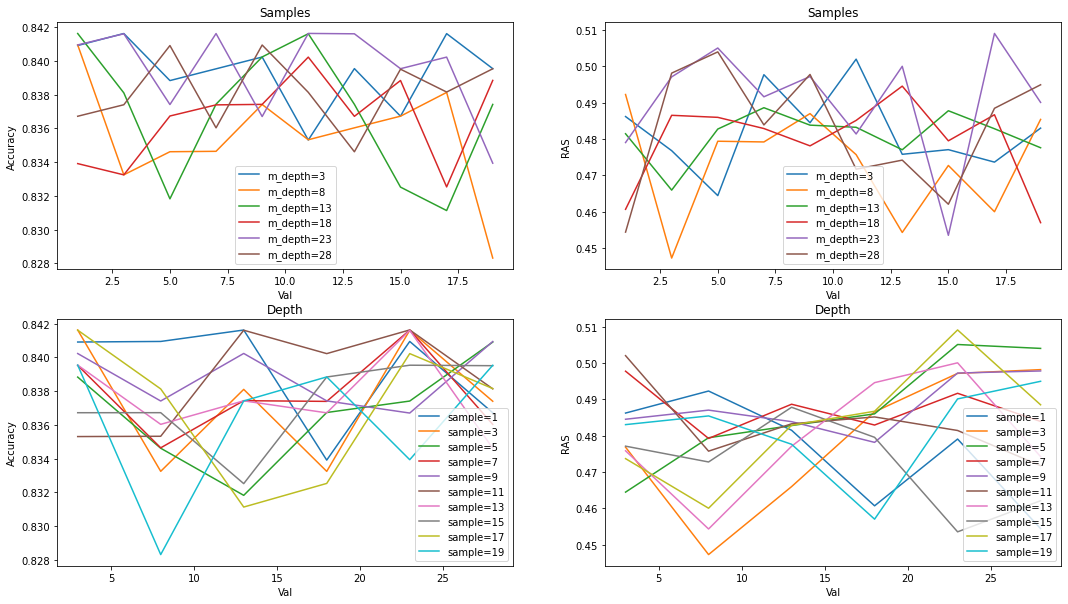

In [51]:
fig = plt.figure(figsize=(18, 10))

fig.add_subplot(221)
plt.title('Samples')
plt.ylabel('Accuracy')
plt.xlabel('Val')

for m_depth, vals in samples['acc_res'].items():
    plt.plot(samples_range, vals, label=f'{m_depth=}')

plt.legend()

fig.add_subplot(222)
plt.title('Samples')
plt.ylabel('RAS')
plt.xlabel('Val')

for m_depth, vals in samples['ras_res'].items():
    plt.plot(samples_range, vals, label=f'{m_depth=}')

plt.legend()

fig.add_subplot(223)
plt.title('Depth')
plt.ylabel('Accuracy')
plt.xlabel('Val')

for sample, vals in depth['acc_res'].items():
    plt.plot(depth_range, vals, label=f'{sample=}')

plt.legend()

fig.add_subplot(224)
plt.title('Depth')
plt.ylabel('RAS')
plt.xlabel('Val')

for sample, vals in depth['ras_res'].items():
    plt.plot(depth_range, vals, label=f'{sample=}')

plt.legend()

plt.show()

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [58]:
kf = KFold(n_splits=5, shuffle=True)

importance = defaultdict(float)

for train_index, val_index in kf.split(X):
    model = MyDecisionTreeClassifier(max_depth=23, min_samples_split=11)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model.fit(X_train, y_train)
    new_imp = model.get_feature_importance()
    importance = {k: importance.get(k, 0) + new_imp.get(k, 0)
                  for k in set(importance) | set(new_imp)}

In [59]:
importance

{0: -5.483606302030279,
 1: 0.4853026924399142,
 2: 0.47570691781091223,
 3: 0.03147145973211368,
 4: 0.11323437719490657,
 5: 0.1384843626485991,
 6: 0.37835934020712747,
 7: 0.07274886101306294,
 8: 0.061568777047892376,
 9: 0.06375442739079087,
 10: 0.003831891753306005,
 11: 0.019444040117727962,
 12: 0.201834678040891,
 13: 0.05945003416668637,
 16: 0.0877914951989025,
 17: 0.09232197679638221,
 18: 0.038551049051628775,
 19: 0.0771907277078983,
 22: 0.14436704489206736,
 23: 0.005828529845553265,
 25: 0.005544148858535769,
 26: 0.017911127457904463,
 27: 0.011088065300417727,
 28: 0.10532547699214373,
 29: 0.05540650052142365,
 30: 0.1946746556648173,
 31: 0.0062343793514680335}

In [60]:
imps = np.array(list(importance.values()))
sorted_ind = np.argsort(imps)[::-1]
pd.DataFrame(imps[sorted_ind], prep_data.columns[np.array(
    list(importance.keys()))[sorted_ind] + 1], ['Weights']).head(10)

,Weights
samerace,0.485303
age,0.475707
race,0.378359
career_c,0.201835
amb3_1,0.194675
intel2_1,0.144367
tuition,0.138484
mn_sat,0.113234
fun3_1,0.105325
fun1_1,0.092322


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

